# Model Experimentation

Project: **Predicting Shipment Outcomes and Inferring Causes of Potential Disruptions**  
Created by: **Fauzan Pasaribu**

The objective of the project is to create a model that can predict the shipment outcome of a particular order item. If the model predicts that the shipment of the order item encounters disruptions, the model would then deduce the causes of such disruption.

**In this notebook, we are expanding our baseline model and experimenting with other machine learning models in order to come up with the best possible model.**

# Contents
1. [Data Loading](#Data-Loading)<br>
2. [Model Evaluation Functions](#Model-Evaluation-Functions)<br>
3. [Expanding on our Baseline Model](#Expanding-on-our-Baseline-Model)<br>
    a.[Optimizing the Hyperparameters](#Optimizing-the-Hyperparameters)<br>
4. [Logistic Regression on All Features](#Logistic-Regression-on-All-Features)<br>
5. [Decision Tree](#Decision-Tree)<br>
6. [Incorporating PCA on the Models](#Incorporating-PCA-on-the-Models)<br>
7. [Model Summary and Conclusion](#Model-Summary-and-Conclusion)<br>

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#ignores warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the data
df = pd.read_csv("Datasets/independent_DataCoSupplyChainDataset.csv")

In [3]:
df.sample(5)

,Sales per customer,Delivery Status,Longitude,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Type_TRANSFER,Category Name_Cardio Equipment,Category Name_Cleats,Category Name_Fishing,...,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Order Status_SUSPECTED_FRAUD,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,order_month,order_year
178538,92.959999,0,-87.937843,0.07,0.47,2,0,0,0,0,...,0,0,0,0,0,0,0,1,4,2015
178599,98.959999,0,-66.370621,0.01,0.08,2,0,0,0,0,...,0,0,0,0,0,0,0,1,4,2015
122320,180.000000,0,-66.370506,0.10,0.35,4,1,0,0,0,...,0,0,0,0,1,1,0,0,5,2016
138973,371.980011,1,-117.104652,0.07,0.20,1,0,0,0,1,...,0,0,1,0,0,0,0,1,2,2017
177015,218.360001,1,-66.370628,0.09,0.36,4,0,0,1,0,...,0,0,0,0,0,1,0,0,4,2015


In [4]:
df.shape

(180516, 43)

## Model Evaluation Functions

I am going to define functions that would help streamline the model evaluation process

In [5]:
#define our own false positive rate calculation, as sklearn does not have this functionality
def false_positive_rate(y_true, y_pred):
    
    false_positives = (y_true == 0) & (y_pred == 1) # find all values where y is negative
                                                    # but we predicted positive
    false_positive_number = false_positives.sum()

    true_negatives = (y_true == 0) & (y_pred == 0)  # find all values where y is negative
                                                    # and we predicted negative
    true_negative_number = true_negatives.sum()

    # Finally, find the ratio of (FP) to (TN + FP)
    FPR = false_positive_number/(true_negative_number + false_positive_number)
    
    return FPR

In [6]:
#Getting AUC score
def auc_evaluation(X_train, X_test, y_train, y_test, model):
    
    from sklearn.metrics import recall_score

    #Get the probability for each point in the test set.
    y_proba = model.fit(X_train, y_train).predict_proba(X_test)[:,1]
    thresholds = np.linspace(0, 1, 100)

    # Iterate over the thresholds and compute the positive and negative recall
    true_positive_rates = []
    false_positive_rates = []

    thresholds = np.linspace(0, 1, 50)
    for threshold in thresholds:

        # Apply the cutoff and calculate the positive and negative recall
        y_pred = np.where(y_proba > threshold, 1, 0)

        tpr = recall_score(y_test, y_pred)
        fpr = false_positive_rate(y_test, y_pred)

        true_positive_rates.append(tpr)
        false_positive_rates.append(fpr)

    # True positive rate (TPR) = recall
    tprs = np.array(true_positive_rates)

    # False positive rate (FPR)
    fprs = np.array(false_positive_rates)

    from sklearn.metrics import roc_curve, roc_auc_score

    #Get the probability for each point in the train set.
    y_proba_train = model.predict_proba(X_train)[:,1]

    # Compute ROC curve and AUC for for the one class
    fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train)
    roc_auc_test = roc_auc_score(y_test, y_proba)

    # Plot the ROC curve.
    plt.figure()
    plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
    plt.plot(fprs, tprs, lw=2, label='test')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC and AUC')
    plt.legend(loc="best")
    plt.show()
    print(f"Train AUC score: {roc_auc_train}")
    print(f"Test AUC score: {roc_auc_test}")

In [7]:
#Getting model accuracy
def model_accuracy(X_train, X_test, y_train, y_test, model):
       
    model.fit(X_train, y_train)
    
    trainacc = model.score(X_train, y_train)
    testacc = model.score(X_test, y_test)
    
    print(f"Train Accuracy: {trainacc}")
    print(f"Test Accuracy: {testacc}")

## Expanding on our Baseline Model

Let's optimize our baseline model by modifying its hyperparameters and experiment with scaling the features.

To recall, the baseline model has the following structure:
- Vanilla logistic regression
- 1 feature: Shipping Mode_Standard Class
- Binary target variable: 0 - Failed Delivery; 1 - Successful Delivery

In [8]:
#Our baseline model
X = df[["Shipping Mode_Standard Class"]]
y = df["Delivery Status"]

I am going to split the data into train-test sets with a **70-30 split**:

In [9]:
#70-30 split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     random_state=123, stratify = y)

### Optimizing the Hyperparameters

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Here, I am going to optimize a hyperparameter of logistic regression:

In [11]:
# Create placeholders
estimators = [
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
]

my_pipe = Pipeline(estimators)

We can then specify the combinations to try out in our grid search:

In [12]:
# One model, 4 scalers, 11 C-values, 5 solvers
# 5-fold Cross Validation


param_grid = [
    {
        'scaler': [StandardScaler(), RobustScaler(), MinMaxScaler(), None],
        'model': [LogisticRegression()], 
        'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'model__solver' : ['saga', 'liblinear', 'lbfgs', 'newton-cg', 'sag']
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

In [13]:
fittedgrid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=1e-06, solver='liblinear'))])

The best parameters for our baseline model are:
- C = **0.000001**
- solver = **liblinear**
- scaler = **StandardScaler**

#### Model 1.6

In [14]:
#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [15]:
model = LogisticRegression(C=0.00001, solver='liblinear', random_state=123)

In [16]:
model_accuracy(X_train, X_test, y_train, y_test, model)

Train Accuracy: 0.6819904875713234
Test Accuracy: 0.6843135444557289


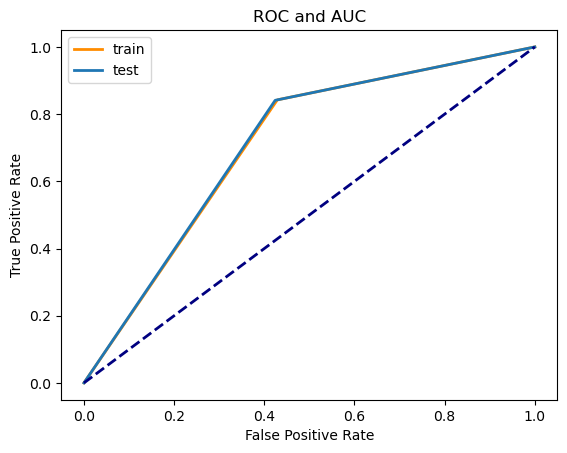

Train AUC score: 0.7067473615628121
Test AUC score: 0.7085063253518847


In [17]:
auc_evaluation(X_train, X_test, y_train, y_test, model)

We get a model test accuracy of **68.43%** and a test AUC score of **0.7085**. This optimized version of the baseline model does not increase the accuracy and did not improve the AUC score at all.

## Logistic Regression on All Features

We fine tuned our baseline model which has only one feature variable. Here, I will fine tune a logistic regression model with all the processed features that we have.

In [18]:
X = df.drop("Delivery Status", axis=1)
y = df["Delivery Status"]

In [19]:
#70-30 split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     random_state=123, stratify = y)

In [20]:
#Scaling using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Optimizing the C:

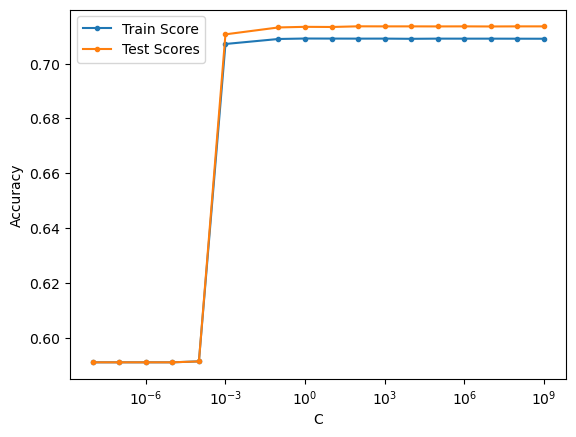

In [21]:
test_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=123)
    my_logreg.fit(X_train,y_train)
    
    # train on traning set
    train_scores.append(my_logreg.score(X_train,y_train))
    # score on test set
    test_scores.append(my_logreg.score(X_test,y_test))
    
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, test_scores,label="Test Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see the C gets better above C = 0.001.

Optimizing all the hyperparameters:

In [22]:
#70-30 split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     random_state=123, stratify = y)

In [23]:
# Create placeholders
estimators = [
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
]

my_pipe = Pipeline(estimators)

In [24]:
# One model, 3 scalers, 7 C-values, 3 solvers
# 5-fold Cross Validation


param_grid = [
    {
        'scaler': [StandardScaler(), RobustScaler(), None],
        'model': [LogisticRegression()], 
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__solver' : ['saga', 'liblinear', 'lbfgs']
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

In [25]:
fittedgrid.best_estimator_

Pipeline(steps=[('scaler', None),
                ('model', LogisticRegression(C=100, solver='liblinear'))])

The best parameters for the Logistic Regression model with all features:

- C = **100**
- solver = **liblinear**
- scaler = **None**

**Model 2.0**

In [95]:
#70-30 split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     random_state=123, stratify = y)

In [96]:
model = LogisticRegression(C=100, solver='liblinear', random_state=123)

In [97]:
model_accuracy(X_train, X_test, y_train, y_test, model)

Train Accuracy: 0.7089291790979811
Test Accuracy: 0.7133782660880805


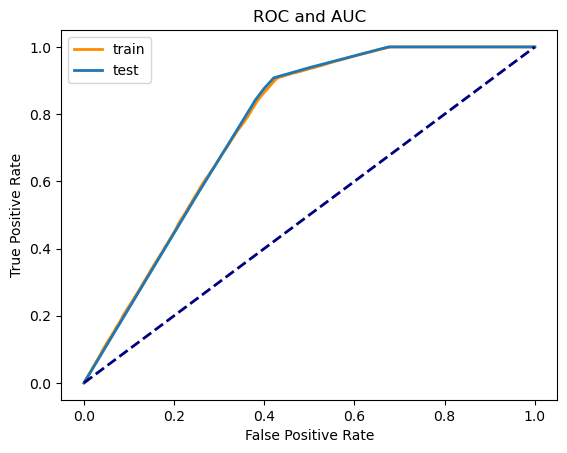

Train AUC score: 0.7638352111316632
Test AUC score: 0.7636480053240886


In [98]:
auc_evaluation(X_train, X_test, y_train, y_test, model)

For model 2.0 using Logistic Regression on all our preprocessed features, we get a Test Accuracy of **71.34%** and an AUC score of **0.7636**. This is quite an improvement from our baseline!

## Decision Tree

Next, I am going to experiment with another model: Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

I am going to get all the features from the preprocessed data as our independent variables.

In [31]:
X = df.drop("Delivery Status", axis=1)
y = df["Delivery Status"]

In [32]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                        random_state=123)

In [33]:
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(random_state = 123)

model_accuracy(X_train, X_test, y_train, y_test, DT_model)

Train Accuracy: 0.9999920861658265
Test Accuracy: 0.6938602160465331


With max_depth equals the number of features we have, we get a model that heavily overfits the train data, and this is expected for a Decision Tree model. Therefore, let's find the optimal max_depth paramater next.

Best test scores given by:
    Depth  Test Score  Train Score
17   18.0    0.718235     0.777107 




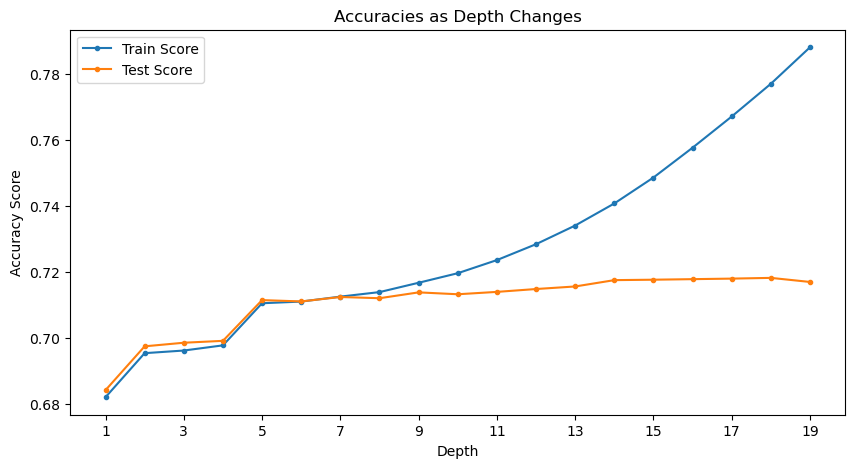

In [34]:
# plotting the train and test score
scores = pd.DataFrame()

depth_range = 20

# loop through the max depth values
for max_depth in range(1, depth_range):
    dt_model = DecisionTreeClassifier(max_depth=max_depth)
    dt_model.fit(X_train, y_train)
    
    # scoring
    train_score = dt_model.score(X_train, y_train)
    test_score = dt_model.score(X_test, y_test)
    
    # append results
    scores = scores.append({'Depth': max_depth, 'Train Score': train_score, 'Test Score': test_score}, ignore_index=True)

# best parameter
best_score = scores['Test Score'].max()
print("Best test scores given by:")
print(scores[scores['Test Score'] == best_score], "\n\n")

# comparison plot
plt.figure(figsize=(10,5))
plt.plot('Depth', 'Train Score', data=scores, marker='.')
plt.plot('Depth', 'Test Score', data=scores, marker='.')
plt.title('Accuracies as Depth Changes')
plt.xlabel('Depth')
plt.xticks(range(1,depth_range, 2))
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

We get the best max_depth at 9 where it does not overfit!

Let's run a GridSearchCV to find the best hyperparameters for our decision tree model.

In [35]:
# Create placeholders
estimators = [
    ('scaler', RobustScaler()),
    ('model', DecisionTreeClassifier())
]

my_pipe = Pipeline(estimators)

In [36]:
#One model, 3 scalers, 5 max_depths
#5-fold Cross Validation


param_grid = [
    {
        'scaler' : [None, StandardScaler(), RobustScaler()],
        'model' : [DecisionTreeClassifier()],
        'model__max_depth': [7, 8, 9, 10, 11]
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

In [37]:
fittedgrid.best_estimator_

Pipeline(steps=[('scaler', None),
                ('model', DecisionTreeClassifier(max_depth=11))])

We also got an optimal **max_depth of 11** with **no scaler**, which is expected because Decision Tree is not supposed to affected by scalers.

#### Model 3.0

In [93]:
# Max_depth = 11
# Instantiate & fit the DT
DT_model = DecisionTreeClassifier(max_depth = 11, random_state = 123)

model_accuracy(X_train, X_test, y_train, y_test, DT_model)

Train Accuracy: 0.7249863486360507
Test Accuracy: 0.7096482319268765


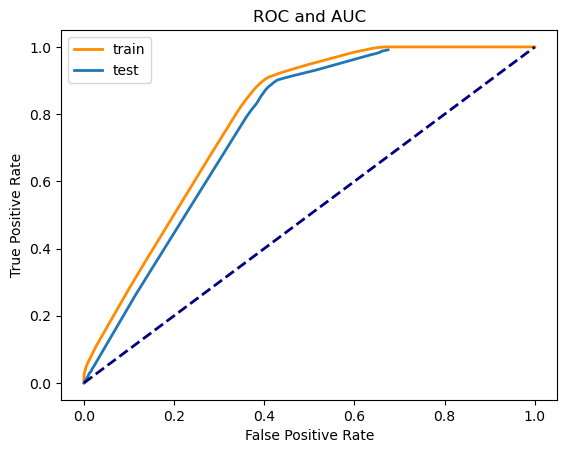

Train AUC score: 0.7875787826329745
Test AUC score: 0.7595004627235326


In [94]:
auc_evaluation(X_train, X_test, y_train, y_test, DT_model)

So, for our Model 3.0, we have a decision tree with a **max_depth of 11** where the test accuracy is at **70.97%** and a test AUC score of **0.7595**. This model did not have a better accuracy than our previous logistic regression model (model 2.0), and only improved a little bit on AUC score.

## Incorporating PCA on the Models

I want to look at how reducing the dimensionality affects the performance of the models we have tested so far. We will be used **Principal Component Analysis** (PCA) as the dimensionality reduction technique.

In [40]:
from sklearn.decomposition import PCA

In [41]:
X = df.drop("Delivery Status", axis=1)
y = df["Delivery Status"]

In [42]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                        random_state=123)

Let's fit our data to PCA:

In [43]:
#scaling the data first
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

I chose Robust Scaler here because I know from our EDA that our data has many outliers, and Robust Scaler is known for a scaler that best deals data with many outliers.

In [44]:
#fit and transform PCA
pca = PCA()
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [45]:
#returns the explained variance ratio of each principal components
expl_var = pca.explained_variance_ratio_
expl_var

array([3.01175799e-01, 8.67043961e-02, 6.63756800e-02, 5.00577151e-02,
       4.33205062e-02, 3.92127280e-02, 3.71902849e-02, 3.55299902e-02,
       2.82909439e-02, 2.79218234e-02, 2.63700889e-02, 2.58071818e-02,
       1.87162106e-02, 1.79364572e-02, 1.63820706e-02, 1.45429985e-02,
       1.39381867e-02, 1.38496822e-02, 1.27481377e-02, 1.25822999e-02,
       1.19624835e-02, 1.03334333e-02, 1.01061944e-02, 9.57705453e-03,
       8.35562942e-03, 7.18451464e-03, 7.04255722e-03, 6.79270458e-03,
       6.11811420e-03, 5.84434368e-03, 5.52206768e-03, 5.08670633e-03,
       3.53937273e-03, 3.47859865e-03, 3.30446744e-03, 2.46960389e-03,
       1.69375937e-03, 1.37209049e-03, 6.50041944e-04, 5.29627965e-04,
       3.83453274e-04, 5.93964533e-32])

In [46]:
#returns the cumulative sum of the explained variance ratio
cumulative_sum = np.cumsum(expl_var)
cumulative_sum

array([0.3011758 , 0.38788019, 0.45425587, 0.50431359, 0.5476341 ,
       0.58684682, 0.62403711, 0.6595671 , 0.68785804, 0.71577987,
       0.74214996, 0.76795714, 0.78667335, 0.80460981, 0.82099188,
       0.83553487, 0.84947306, 0.86332274, 0.87607088, 0.88865318,
       0.90061566, 0.9109491 , 0.92105529, 0.93063235, 0.93898798,
       0.94617249, 0.95321505, 0.96000775, 0.96612587, 0.97197021,
       0.97749228, 0.98257898, 0.98611836, 0.98959696, 0.99290142,
       0.99537103, 0.99706479, 0.99843688, 0.99908692, 0.99961655,
       1.        , 1.        ])

Here we see that we need at least **20 Principal Components** to get at least a cumulative explained variance ratio of 0.90.

The amount of principal components needed to get a cum. explained variance ratio of 0.90 may differ as we change scalers.

I am going to perform a GridSearchCV on multiple models while incorporating PCA as the dimensionality reduction technique:

In [47]:
# Create placeholders
estimators = [
    ('scaler', RobustScaler()),
    ('reduce_dim', PCA()),
    ('model', DecisionTreeClassifier())
]

my_pipe = Pipeline(estimators)

We can then specify the combinations to try out in our grid search:

In [48]:
# Two models, 2 scalers, 3 n_components
# Decision Tree has 3 max_depths
# Logistic regression has 4 Cs
# 5-fold Cross Validation


param_grid = [
    {
        'scaler' : [StandardScaler(), RobustScaler()],
        'reduce_dim' : [PCA()],
        'model' : [DecisionTreeClassifier()],
        'model__max_depth': [8, 9, 10],
        'reduce_dim__n_components': [0.90, 0.87, 0.85]
    },
    {
        'scaler' : [StandardScaler(), RobustScaler()],
        'reduce_dim' : [PCA()],
        'model' : [LogisticRegression()],
        'model__C': [0.1, 1, 10, 100],
        'reduce_dim__n_components': [0.90, 0.87, 0.85]
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

In [49]:
fittedgrid.best_estimator_

Pipeline(steps=[('scaler', RobustScaler()),
                ('reduce_dim', PCA(n_components=0.85)),
                ('model', DecisionTreeClassifier(max_depth=8))])

The best model for our the PCA-incorporated model is the following:
- model = **Decision Tree**
- scaler = **Robust Scaler**
- n_components = **0.85**
- C = **1**

Let's see what the how many Principal Components there are using this model:

In [85]:
X = df.drop("Delivery Status", axis=1)
y = df["Delivery Status"]

In [86]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                        random_state=123)

In [87]:
#scaling the data first
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [88]:
#fit and transform
pca = PCA(n_components=0.85)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [89]:
expl_var = pca.explained_variance_ratio_

#returns the cumulative sum of the explained variance ratio
cumulative_sum = np.cumsum(expl_var)
cumulative_sum

array([0.3011758 , 0.38788019, 0.45425587, 0.50431359, 0.5476341 ,
       0.58684682, 0.62403711, 0.6595671 , 0.68785804, 0.71577987,
       0.74214996, 0.76795714, 0.78667335, 0.80460981, 0.82099188,
       0.83553487, 0.84947306, 0.86332274])

In [90]:
#returns the number of features and principal components
print(f"The number of original feature variables is: {X.shape[1]}")
print(f"The number of principal components is: {cumulative_sum.shape[0]}")

The number of original feature variables is: 42
The number of principal components is: 18


There are a total of 18 Principal Components to make up a cumulative explained variance ratio of 0.85. We originialy had 42 feature variables, so PCA only reduced the dimensionality by 24.

**Model 4.0**

In [91]:
model = DecisionTreeClassifier(max_depth=8, random_state=123)
model_accuracy(X_train, X_test, y_train, y_test, model)

Train Accuracy: 0.7145321736928324
Test Accuracy: 0.7100914043024652


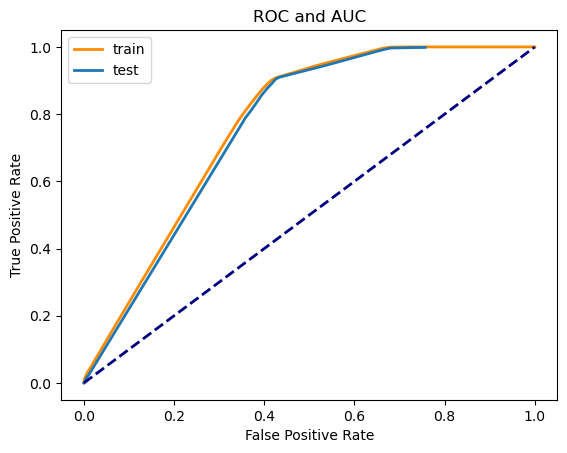

Train AUC score: 0.7709828418956757
Test AUC score: 0.7614914391837871


In [92]:
auc_evaluation(X_train, X_test, y_train, y_test, model)

Model 4.0 uses PCA as a dimensionality reducer and use it on several versions of models. The best one we got has a test accuracy of **71.01** and an AUC score of **0.7615**. This model is better than our baseline model in terms of accuracy and barely has lots of improvement in AUC score; therefore using PCA in this case did  help in improving the performance of the models.

## Ensemble Learning

Let's experiment with using ensemble learning methods!

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
X = df.drop("Delivery Status", axis=1)
y = df["Delivery Status"]

In [60]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                        random_state=123)

Here, I have three ensemble learning methods: XGBoost, AdaBoost, and Random Forest. These methods are based on decision trees, and decision trees are not sensitive to the scale of the input features. Therefore, it is not necessary to scale the data. 

Let's see how accurate each ensemble learning method is:

In [61]:
#Fit each method and return its accuracy score
xgb_model = XGBClassifier(random_state=123)
ab_model = AdaBoostClassifier(random_state=123)
rf_model = RandomForestClassifier(random_state=123)

xgb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

print("Train Set Scores:")
print(f"XG Boost score: {xgb_model.score(X_train, y_train)}")
print(f"AdaBoost score: {ab_model.score(X_train, y_train)}")
print(f"Random Forest score: {rf_model.score(X_train, y_train)}\n")

print("Test Set Scores:")
print(f"XG Boost score: {xgb_model.score(X_test, y_test)}")
print(f"AdaBoost score: {ab_model.score(X_test, y_test)}")
print(f"Random Forest score: {rf_model.score(X_test, y_test)}")

Train Set Scores:
XG Boost score: 0.7558107327419061
AdaBoost score: 0.7078054146453415
Random Forest score: 0.9999841723316529

Test Set Scores:
XG Boost score: 0.7232573169605762
AdaBoost score: 0.7090019388791432
Random Forest score: 0.7233865755701228


Random Forest can be seen heavily overfitting the train data. Based on the test scores only, Random Forest performs the best followed by XGBoost. Next, let's see how each method's f-1 scores.

In [62]:
#getting the precision, recall, and f1 score of each ensemble learning method
y_pred_xgb = xgb_model.predict(X_test)
y_pred_ab = ab_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("XGBoost")
print(classification_report(y_test, y_pred_xgb),"\n")
print("AdaBoost")
print(classification_report(y_test, y_pred_ab),"\n")
print("Random Forest")
print(classification_report(y_test, y_pred_rf),"\n")

XGBoost
              precision    recall  f1-score   support

           0       0.86      0.64      0.73     31872
           1       0.62      0.85      0.72     22283

    accuracy                           0.72     54155
   macro avg       0.74      0.74      0.72     54155
weighted avg       0.76      0.72      0.72     54155
 

AdaBoost
              precision    recall  f1-score   support

           0       0.85      0.61      0.71     31872
           1       0.60      0.85      0.71     22283

    accuracy                           0.71     54155
   macro avg       0.73      0.73      0.71     54155
weighted avg       0.75      0.71      0.71     54155
 

Random Forest
              precision    recall  f1-score   support

           0       0.80      0.71      0.75     31872
           1       0.64      0.74      0.69     22283

    accuracy                           0.72     54155
   macro avg       0.72      0.73      0.72     54155
weighted avg       0.73      0.72      

XGBoost and Random Forest looks like they are on par when looking at the f-1 scores. AdaBoost still performs the worst. Lastly, let's see how each AUC scores look like.

XGBoost


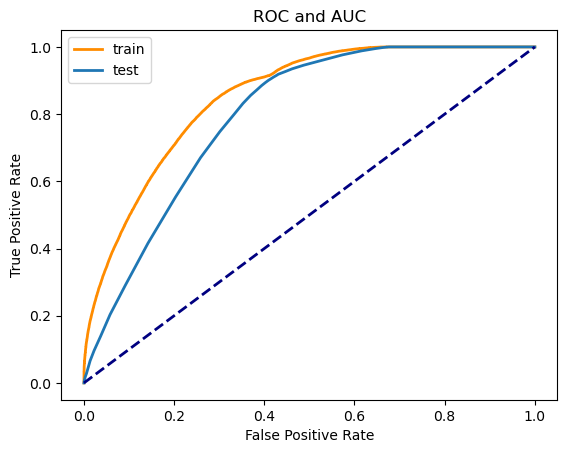

Train AUC score: 0.8533902162840786
Test AUC score: 0.796912123852183
None 

AdaBoost


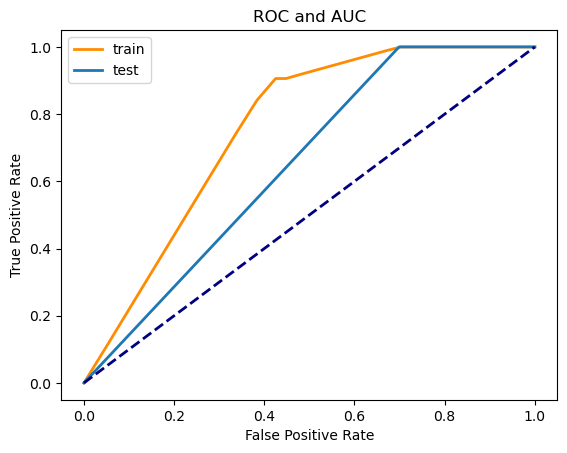

Train AUC score: 0.7587978653767458
Test AUC score: 0.7598764949399536
None 

Random Forest


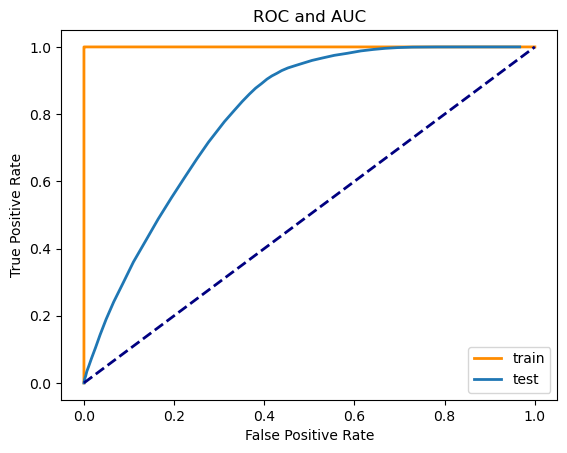

Train AUC score: 0.9999999987031216
Test AUC score: 0.8032065567333734
None 



In [63]:
#AUC score for XGBoost
print("XGBoost")
print(auc_evaluation(X_train, X_test, y_train, y_test, xgb_model),"\n")

#AUC score for AdaBoost
print("AdaBoost")
print(auc_evaluation(X_train, X_test, y_train, y_test, ab_model),"\n")

#AUC score for Random Forest
print("Random Forest")
print(auc_evaluation(X_train, X_test, y_train, y_test, rf_model),"\n")

Both XGBoost and Random Forest yields great AUC Scores. Hence, I am going to go deeper on these two ensemble learning methods.

### Random Forest Classifier

To resolve the overfitting issue of Random Forest, let's tune its hyperparameters starting with `n_estimators`.

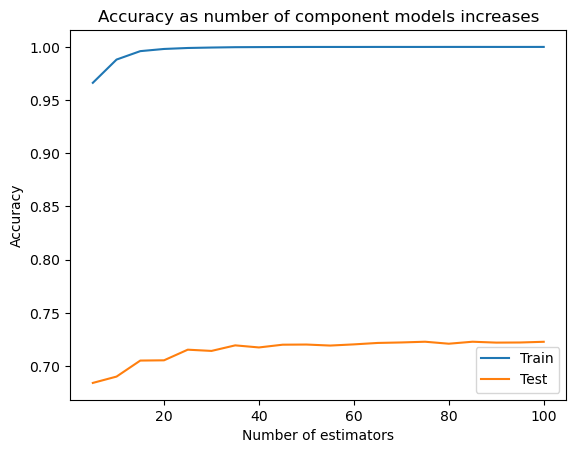

In [64]:
#plots the accuracy as number of component (n_component) increases
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    rf_model = RandomForestClassifier(n_estimators = n)
    rf_model.fit(X_train, y_train)
    train_scores.append(rf_model.score(X_train, y_train))
    test_scores.append(rf_model.score(X_test, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

We see that at every point, the model overfits. So, let's explore another hyperparameter, `max_depth`:

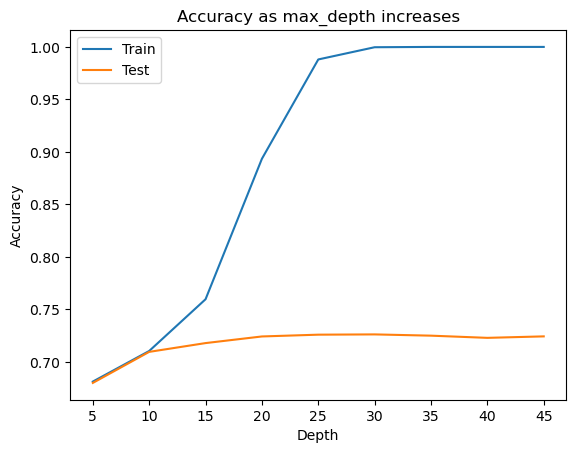

In [65]:
#plots the relationship between accuracy and the max_depth
train_scores = []
test_scores = []
n_range = range(5, 50, 5)
for n in n_range:
    rf_model = RandomForestClassifier(max_depth = n)
    rf_model.fit(X_train, y_train)
    train_scores.append(rf_model.score(X_train, y_train))
    test_scores.append(rf_model.score(X_test, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy as max_depth increases")
plt.legend();

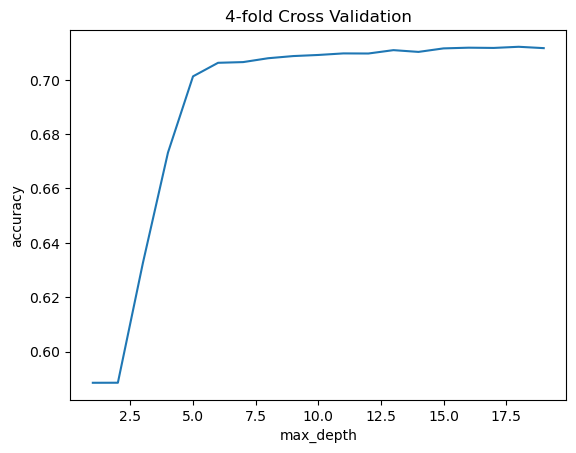

In [66]:
from sklearn.model_selection import cross_val_score
# Define our list of values to try out
max_depth = range(1, 20, 1)

# Create a list to hold our cross-validation scores
cv_scores = []

for n in max_depth:
    
    # Instantiate a XGBoost classifier
    model = RandomForestClassifier(max_depth = n)
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(model, X_test, y_test, cv=4)
    cv_scores.append(np.mean(scores))
    
plt.figure()
plt.plot(max_depth, cv_scores)
plt.title("4-fold Cross Validation")
plt.xlabel('max_depth')
plt.ylabel('accuracy') 
plt.show()

From the graph above, I am going to choose `max_depth` = 10 because that is where the test accuracy elbowed, and any point above that the model overfits heavily. The cross validation graph also shows that at that range, the accuracy is maximized. Now, let's go back and see what the best `n_estimators` is for a random forest with max_depth of 10.

##### Random Forest: max_depth = 10

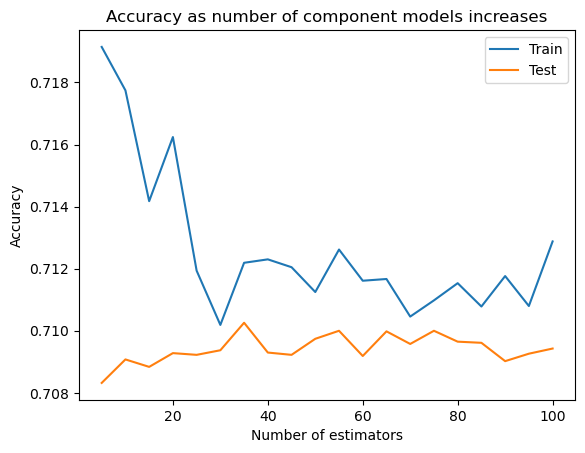

In [67]:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    rf_model = RandomForestClassifier(n_estimators = n, max_depth = 10)
    rf_model.fit(X_train, y_train)
    train_scores.append(rf_model.score(X_train, y_train))
    test_scores.append(rf_model.score(X_test, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

As we can see, both accuracies converges the closest at `n_estimators` = 95. Thus, I am going to choose `n_estimators` = 95.

#### Model 5.0

In [68]:
model = RandomForestClassifier(n_estimators = 95, max_depth = 10, random_state=123)
model_accuracy(X_train, X_test, y_train, y_test, model)

Train Accuracy: 0.7105198597668585
Test Accuracy: 0.7098144215677222


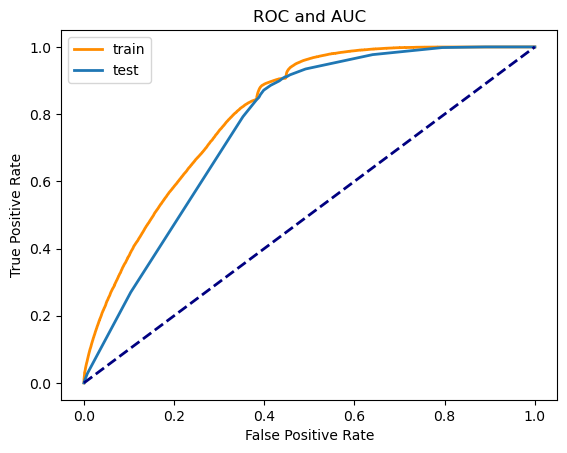

Train AUC score: 0.8098855218355996
Test AUC score: 0.7701891562457701


In [69]:
auc_evaluation(X_train, X_test, y_train, y_test, model)

The Random Forest model has a test accuracy of **70.98%** and an AUC Score of **0.7702**. This is so far our best model!

### XGBoost

The next ensemble learning method we experiment with is XGBoost. The first hyperparameter we will fine-tune is the `max_depth` before looking at the n_estimators:

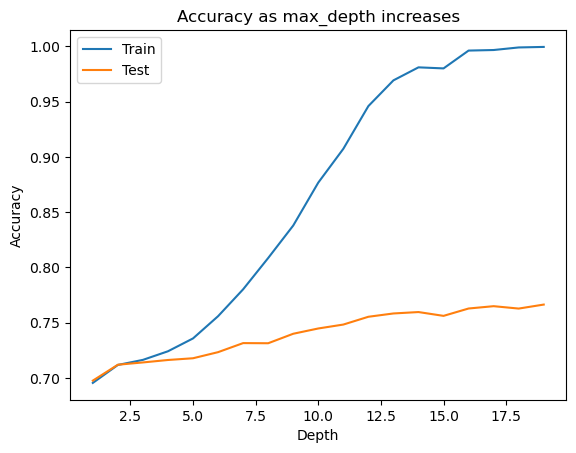

In [70]:
train_scores = []
test_scores = []
n_range = range(1, 20, 1)
for n in n_range:
    xgb_model = XGBClassifier(max_depth = n)
    xgb_model.fit(X_train, y_train)
    train_scores.append(xgb_model.score(X_train, y_train))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy as max_depth increases")
plt.legend();

In the graph above, there is not any elbow for the test accuracy line making it abit harder for us to choose what max_depth is best. However, I would choose a max_depth between a range of 2 to 8, as this range gives a robust fit. I am going to create a 4-fold cross validation for checking which max_depth would give the best accuracy without overfitting.

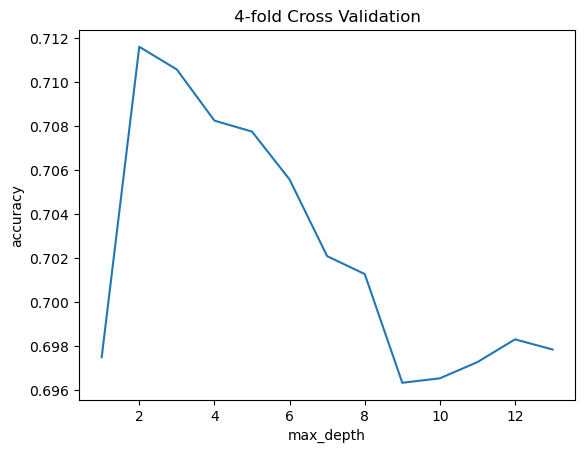

In [71]:
from sklearn.model_selection import cross_val_score
# Define our list of values to try out
max_depth = range(1, 14, 1)

# Create a list to hold our cross-validation scores
cv_scores = []

for n in max_depth:
    
    # Instantiate a XGBoost classifier
    model = XGBClassifier(max_depth = n)
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(model, X_test, y_test, cv=4)
    cv_scores.append(np.mean(scores))
    
plt.figure()
plt.plot(max_depth, cv_scores)
plt.title("4-fold Cross Validation")
plt.xlabel('max_depth')
plt.ylabel('accuracy') 
plt.show()

Here, we can see that there is a peak of accuracy at `max_depth` = 2; therefore, I will choose that as the best value for the parameter.

##### XGBoost: max_depth = 2

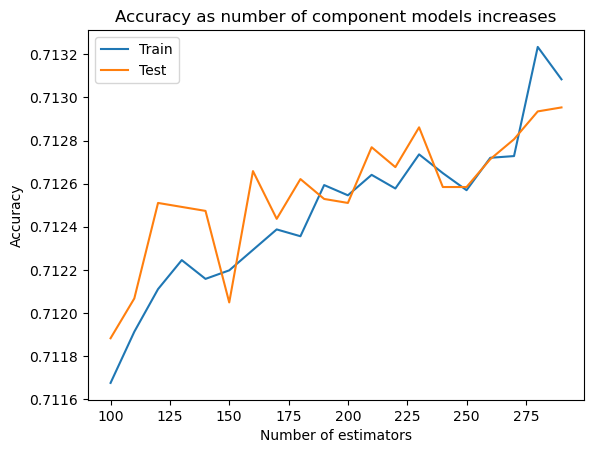

In [72]:
train_scores = []
test_scores = []
n_range = range(100, 300, 10)
for n in n_range:
    xgb_model = XGBClassifier(n_estimators = n, max_depth = 2)
    xgb_model.fit(X_train, y_train)
    train_scores.append(xgb_model.score(X_train, y_train))
    test_scores.append(xgb_model.score(X_test, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

Here, we have the same problem as before where the test accuracy does not have a visible elbow. I am going to, again, perform a 4-fold cross validation to find the best number of estimators (n_estimators) with an XGBoost of max_depth of 2.

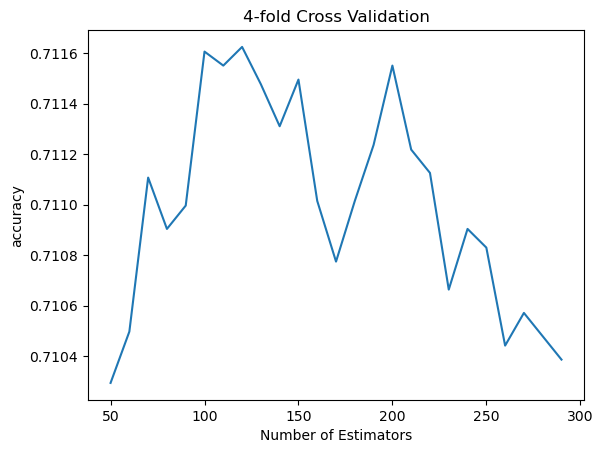

In [73]:
from sklearn.model_selection import cross_val_score
# Define our list of values to try out
n_estimators = range(50, 300, 10)

# Create a list to hold our cross-validation scores
cv_scores = []

for n in n_estimators:
    
    # Instantiate a XGBoost classifier
    model = XGBClassifier(n_estimators = n, max_depth = 2)
    # Calculate the 4 validation scores via cross-val & append average to list
    scores = cross_val_score(model, X_test, y_test, cv=4)
    cv_scores.append(np.mean(scores))
    
plt.figure()
plt.plot(n_estimators, cv_scores)
plt.title("4-fold Cross Validation")
plt.xlabel('Number of Estimators')
plt.ylabel('accuracy') 
plt.show()

There is a peak at n_estimators = 130. Therefore, I will choose `n_estimators` = 130 as the best value for the n_estimators hyperparameter.

#### Model 5.1

In [74]:
model = XGBClassifier(n_estimators = 130, max_depth = 2, random_state=123)
model_accuracy(X_train, X_test, y_train, y_test, model)

Train Accuracy: 0.7122450756166855
Test Accuracy: 0.7124919213369033


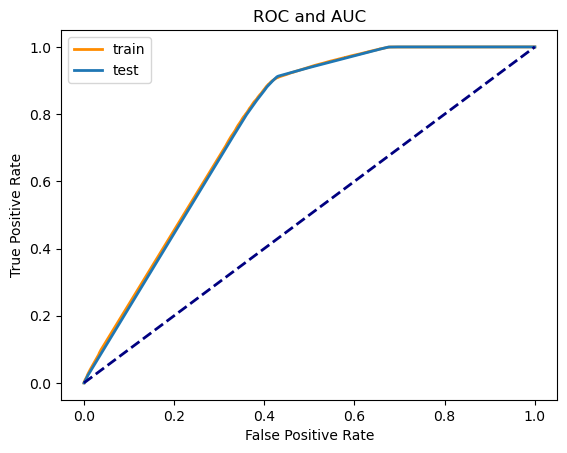

Train AUC score: 0.7677165555969772
Test AUC score: 0.7647565682613323


In [75]:
auc_evaluation(X_train, X_test, y_train, y_test, model)

The XGBoost model has a test accuracy of **71.25%** and an AUC Score of **0.7648**. This model has slightly better accuracy than Random Forest, but a slightly worse AUC score.

## Model Summary and Conclusion


| Model | Variables                                 | Test Accuracy    | AUC Score | Type |
|-------|--------------------------------------------|-------|------|----|
| 1.0 (Baseline)   | Shipping Mode_Standard Class                                        | 68.27% | 0.7085 | Vanilla Logreg
| 1.6   | Shipping Mode_Standard Class                    | 68.43% | 0.7085 | Optimized Logreg |
| 2.0 | All (39 features) |  71.34% | 0.7636| Optimized Logreg |
| 3.0 | All |  70.97% | 0.7595| Optimized Decision Tree |
| 4.0 | 29 PCA components | 71.01% | 0.7615|Optimized Decision Tree with PCA |
| 5.0 | All | 70.98% | 0.7702|Random Forest Classifier |
| 5.1 | All | 71.25% | 0.7648|XGBoost |

According to our tests so far, the model with the highest accuracy is Model 2.0, and the model with the highest AUC Score is Model 5.0. We have established that a better AUC Score is a better metric for model performance in our case; therefore, the model that I will choose out of all the above is **Model 5.0** that uses a Random Forest Classifier. Additionaly, its accuracy does not differ much with Model 2.0.